In [1]:
from simulate import simulate_convergence
import torch
from utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
import numpy as np
import gpytorch
from configs import N_SIDE_INFERENCE
show_bool = True

# Visualisations for method

Here, we generate the visualisations used in Figure 1. We use the posterior from the dfNGP over the lower Byrd region, which was inferred at high grid resolution (N_side_inference in configs.py).

Input: data from `results_real/dfNGP_grid_inference`  
Output: visualisations saved to `figures_real/gird_inference`

## Plot to explain divergence-free property: df_grid_5x5.png

We programatically produce a small plot to explain the divergence-free constraint.

In [2]:
# Make a small grid of uneven number (since we select central vector in the vis)
_, x = make_grid(n_side = 5)

# Squeeze and offset to center the grid
x = (x * 0.5) + 0.25

# Check index of center value
print(x[12])

# Simulate simple, divergence-free convergence field
y = simulate_convergence(x)

tensor([0.5000, 0.5000])


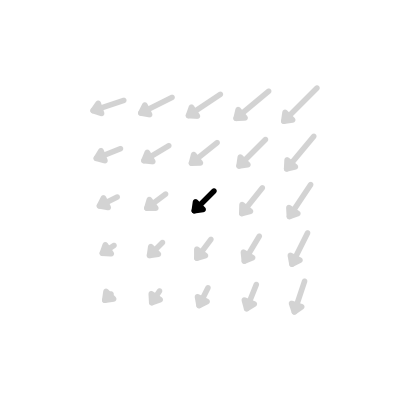

In [3]:
# Flip the y values (vectors) to match the real data shown below
vecs = -y 

# Scale the vectors for visualisation, reducing arrow length
scale = 0.14  
vecs = vecs * scale

# Plot
fig, ax = plt.subplots(figsize = (5, 5))

# Loop through all vectors and plot arrow patches
for i in range(len(x)):
    # Centered line segments so that the arrows are centered on the grid points
    # NOTE: This is different to the default in plt.quiver but preferrable here
    start = x[i] - vecs[i] / 2
    end = x[i] + vecs[i] / 2
    # Highlight the central vector with a different color
    color = "black" if i == 12 else "lightgrey"
    arrow = FancyArrowPatch(
        posA = start, posB = end,
        arrowstyle = '-|>, head_length = 0.4, head_width = 0.3',
        color = color,
        linewidth = 4,
        mutation_scale = 13,
    )
    ax.add_patch(arrow)

ax.set_aspect('equal')
ax.axis('off')

plt.savefig(f"figures_real/grid_inference/df_grid_5x5.png", 
            dpi = 300, bbox_inches = 'tight', pad_inches = 0)

if show_bool:
    plt.show()
plt.close()

## Visualise sparse training data over MODIS for lower Byrd: lower_byrd_modis+train.png

In [4]:
# Load MODIS data for the lower Byrd region
modis_lower = torch.load(
    "data/modis/modis_lower_byrd.pt", 
    weights_only = False)

# Load training data 
x_train_lower = torch.load(
    "/home/kim/ice_thickness/data/real_data/region_lower_byrd_train_tensor.pt", 
    weights_only = False)

print(modis_lower.shape)
print(x_train_lower.shape)

torch.Size([3, 240, 240])
torch.Size([12, 487])


In [5]:
# Extract dimensions from the MODIS data to create matching grid
ny, nx = modis_lower[2, :, :].shape
x_coords = np.linspace(0, 1, nx)
y_coords = np.linspace(0, 1, ny)
x_modis, y_modis = np.meshgrid(x_coords, y_coords)

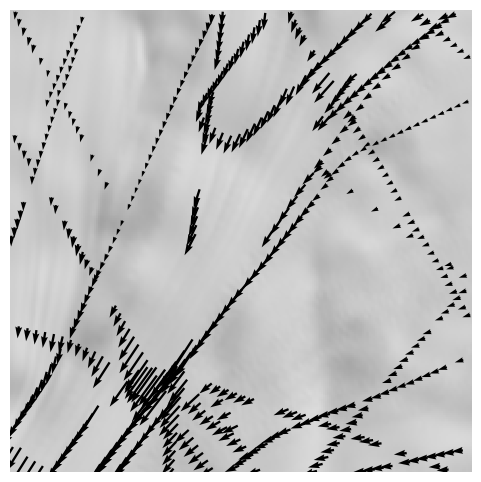

In [6]:
fig, ax = plt.subplots(figsize = (6, 6))

# MODIS background
ax.pcolor(
    x_modis,
    y_modis,
    # Flip the MODIS data to match the orientation
    np.flipud(modis_lower[2, :, :].numpy()),
    cmap = 'gray', 
    vmin = 0, vmax = 20000, 
    shading = 'auto'
)

# Training data vectors
ax.quiver(
    x_train_lower[0, ::1], 
    x_train_lower[1, ::1], 
    x_train_lower[3, ::1], 
    x_train_lower[4, ::1], 
    color = "black",
    scale = 70, 
    width = 0.005,
    # alpha = 0.4
)

# Optional aspect ratio
ax.set_aspect('equal')

# Turn off axes
ax.axis('off')

plt.savefig(f"figures_real/grid_inference/lower_byrd_modis+train.png", 
                dpi = 300, bbox_inches = 'tight', pad_inches = 0)

if show_bool:
    plt.show()
plt.close()

## Visualise posterior sample over MODIS for lower Byrd: lower_byrd_modis+sample.png

- Downsample
- Show flux magnitude in colors

In [7]:
# Load data
mean = torch.load(
    "results_real/dfNGP_grid_inference/region_lower_byrd_dfNGP_grid_mean_predictions.pt", 
    weights_only = False)

latent_covar = torch.load(
    "results_real/dfNGP_grid_inference/region_lower_byrd_dfNGP_grid_latent_covar_predictions.pt", 
    weights_only = False)

covar = torch.load(
    "results_real/dfNGP_grid_inference/region_lower_byrd_dfNGP_grid_covar_predictions.pt", 
    weights_only = False)

# Downsample mean & covar

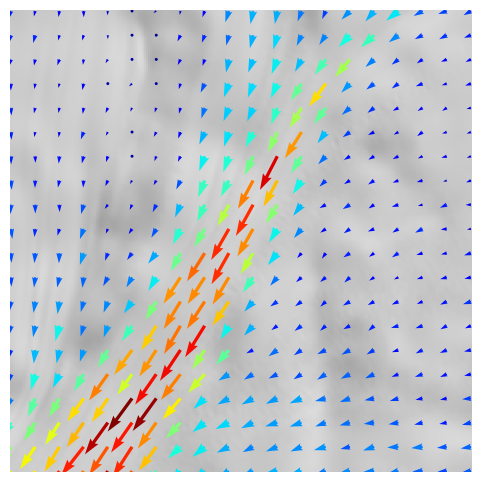

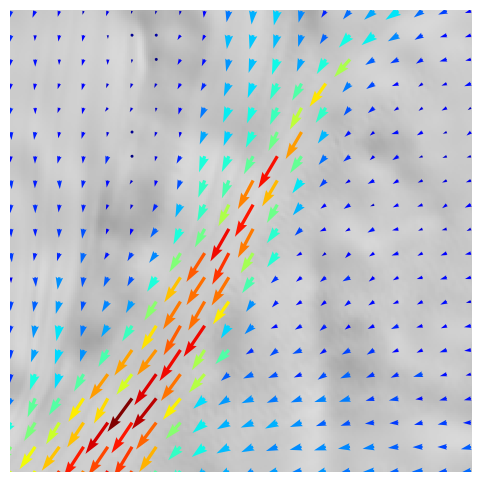

In [15]:
# Define downsampling factor
ds_factor = 3

# number of tasks (2D)
T = 2  

# Downsample mean
mean_2d = mean.reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE, T)
mean_ds = mean_2d[::ds_factor, ::ds_factor, :]  # [15, 15, 2]
mean_ds_flat = mean_ds.reshape(-1, T)

# Downsample covariance
# Original spatial indices: row-major
grid_indices = torch.arange(N_SIDE_INFERENCE * N_SIDE_INFERENCE).reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)
downsampled_indices = grid_indices[::ds_factor, ::ds_factor].reshape(-1)

# For multitask: expand to full index into [N*T, N*T]
task_indices = []
for i in range(T):
    task_indices.append(downsampled_indices * T + i)
inds = torch.stack(task_indices, dim = 1).reshape(-1)  # shape: [225 * 2] = [450]

covar_ds_flat = covar[inds][:, inds]  # shape: [450, 450]

# Define the posterior distribution
posterior = gpytorch.distributions.MultitaskMultivariateNormal(mean_ds_flat, covar_ds_flat)

# Make grid for sample 
N_sample = mean_ds_flat.shape[0]
N_sample_side = int(np.sqrt(N_sample))
_, x = make_grid(n_side = N_sample_side)  # shape [N, 2]

# Loop over samples
for i in range(2):
    sample = posterior.sample().detach().cpu()  # [225, 2]
    sample_magnitude = sample.norm(dim = 1)

    fig, ax = plt.subplots(figsize = (6, 6))

    # MODIS background
    ax.pcolor(
        x_modis,
        y_modis,
        # Flip the MODIS data to match the orientation
        np.flipud(modis_lower[2, :, :].numpy()),
        cmap = 'gray', 
        vmin = 0, vmax = 20000, 
        shading = 'auto')

    # Quivers
    ax.quiver(
        x[:, 0],
        x[:, 1],
        sample[:, 0], 
        sample[:, 1], 
        sample_magnitude.numpy(),
        # Show magnitude of vectors in jet color map
        cmap = 'jet',
        width = 0.007)

    # Optional aspect ratio
    ax.set_aspect('equal')

    # Turn off axes
    ax.axis('off')

    for spine in ax.spines.values():
            spine.set_visible(False)

    plt.savefig(f"figures_real/grid_inference/lower_byrd_modis+sample_{i+1}.png", 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    if show_bool:
        plt.show()
    plt.close()

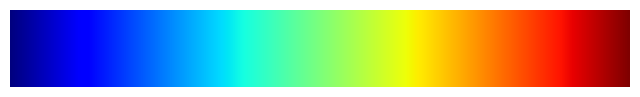

In [16]:
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = "jet")
plt.axis('off')

plt.savefig(f"figures_real/grid_inference/cmap_flux_mag.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)

plt.show()

## Visualise variance over MODIS for lower Byrd: lower_byrd_modis+variance.png

- Keep it high res.

In [ ]:
# Extract variance from diagonal and reconstruct two columns
var = torch.diag(covar).detach().cpu().reshape(N_SIDE_INFERENCE**2, 2)
var = var.sum(dim = -1)  # sum over tasks
var_2d = var.reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)

_, grid_var = make_grid(n_side = N_SIDE_INFERENCE)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap

def truncate_colormap(cmap_name, minval, maxval, n = 256):
    cmap = get_cmap(cmap_name)
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'{cmap_name}_trunc', cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Create a lighter version of Blues
light_blues = truncate_colormap('Blues', 0.0, 0.9)

In [ ]:
# Extract variance from diagonal and reconstruct two columns
var = torch.diag(covar).detach().cpu().reshape(N_SIDE_INFERENCE**2, 2)
# Sum over tasks/columns
var = var.sum(dim = -1)
# Reshape to 2D grid
var_2d = var.reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)
# Exclude outer border to define color max for visualisation
# NOTE: Variance increases at the border but we want to focus on the central area
border = 5
var_2d_cropped_max = var_2d[border:-border, border:-border].max()

_, grid_var = make_grid(n_side = N_SIDE_INFERENCE)
x_var = grid_var[:, 0].reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)
y_var = grid_var[:, 1].reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)

fig, ax = plt.subplots(figsize = (6, 6))

# MODIS background
ax.pcolor(
    x_modis,
    y_modis,
    np.flipud(modis_lower[2, :, :].numpy()), 
    cmap = 'gray', 
    vmin = 0, vmax = 20_000, 
    shading = 'auto',
    # alpha = 0.4
)

# Takes 2d x input, 2d y input, and 2d variable
ax.pcolormesh(
    x_var,
    y_var,
    var_2d,
    cmap = "Blues", # 'PuRd' works
    alpha = 1.0, # 0.5
    vmax = var_2d_cropped_max,
)

# Optional aspect ratio
ax.set_aspect('equal')

# Turn off axes
ax.axis('off')

cut = 0.05
ax.set_xlim(cut, 1 - cut)
ax.set_ylim(cut, 1 - cut)

plt.savefig(f"figures_real/grid_inference/lower_byrd_modis+variance.png", 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0)

if show_bool:
    plt.show()
plt.close()

In [ ]:
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = "Blues", alpha = 1) # 0.5
plt.axis('off')

plt.savefig(f"figures_real/grid_inference/cmap_var.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [ ]:
import numpy as np
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap

# With base cmap
"""
# Choose base colormap (e.g., inferno or magma)
# https://www.radiativetransfer.org/misc/typhon/doc/typhon.plots.cm.html
base = cm.get_cmap('Blues', 256)  # can also try 'magma', 'Reds', etc. 'Blues'

# Extract RGBA values and set alpha to go from 0 to 1
colors = base(np.linspace(0, 1, 256))
colors[:, -1] = np.linspace(0, 1, 256) * 0.6  # last column is alpha

# Create new colormap with variable transparency
cmap_alpha = ListedColormap(colors)
"""

# With base solid color — e.g., RGB for blue 
rgb_255 = np.array([(255, 250, 0)]) # (60, 255, 185) is neon (0, 77, 255) is blue, (83, 66, 255) is purple
rgb_decimal = rgb_255 / 255.0
# print(rgb_decimal)  # custom blue (R, G, B)

# Create 256 levels of that color with increasing alpha
N = 256
colors = np.ones((N, 4))  # RGBA
colors[:, :3] = rgb_decimal  # set RGB
colors[:, 3] = np.linspace(0, 1, N)  # increasing alpha

# Create the colormap
cmap_alpha = ListedColormap(colors)

In [ ]:
# Extract variance from diagonal and reconstruct two columns
var = torch.diag(covar).detach().cpu().reshape(N_SIDE_INFERENCE**2, 2)
# Sum over tasks/columns
var = var.sum(dim = -1)
# Reshape to 2D grid
var_2d = var.reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)
# Exclude outer border to define color max for visualisation
# NOTE: Variance increases at the border but we want to focus on the central area
border = 5
var_2d_cropped_max = var_2d[border:-border, border:-border].max()

_, grid_var = make_grid(n_side = N_SIDE_INFERENCE)
x_var = grid_var[:, 0].reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)
y_var = grid_var[:, 1].reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE)

fig, ax = plt.subplots(figsize = (6, 6))

# MODIS background
ax.pcolor(
    x_modis,
    y_modis,
    np.flipud(modis_lower[2, :, :].numpy()), 
    cmap = 'gray', 
    vmin = 0, vmax = 20_000, 
    shading = 'auto',
    # alpha = 0.4 Note: alpha make the grid show
)

# Takes 2d x input, 2d y input, and 2d variable
ax.pcolormesh(
    x_var,
    y_var,
    var_2d,
    cmap = cmap_alpha, 
    vmax = var_2d_cropped_max,
)

cut = 0.05
ax.set_xlim(cut, 1 - cut)
ax.set_ylim(cut, 1 - cut)

# Optional aspect ratio
ax.set_aspect('equal')

# Turn off axes
ax.axis('off')

plt.savefig(f"figures_real/grid_inference/lower_byrd_modis+variance_alpha.png", 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0)

if show_bool:
    plt.show()
plt.close()

In [ ]:
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = cmap_alpha, alpha = 1) # 0.5
plt.axis('off')

plt.savefig(f"figures_real/grid_inference/cmap_variance_alpha.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)

plt.show()